# tile llc model run and distribute parcels runs


To do:

- [ ] try with different interpolation schemes
- [ ] try with different compiler?
- [X] add online horizontal speed output
- [X] change run tree
- [X] add tracer and sea level interpolation. Pressure will always be recomputed offline
- [X] on the fly parcel seeding


In [1]:
import os, shutil

import numpy as np
import pandas as pd
import xarray as xr
from datetime import timedelta, datetime

#import geopandas

import dask
#from dask.delayed import delayed

#from xmitgcm.llcreader import llcmodel as llc

%matplotlib inline
from matplotlib import pyplot as plt

from parcels import FieldSet, ParticleSet, ParticleFile, plotTrajectoriesFile, Variable
from parcels import JITParticle, ScipyParticle
from parcels import ErrorCode, NestedField, AdvectionEE, AdvectionRK4

import mitequinox.utils as ut
import mitequinox.parcels as pa

In [2]:
from dask.distributed import Client, LocalCluster
from dask_jobqueue import PBSCluster

# ** processes and cores may be adjusted in order to have more memory or inversely more 
# ** computational ressource

processing = 1

if processing==0:
    cluster = LocalCluster()
elif processing==1:
    # parcels simulation
    cluster = PBSCluster(processes=4, cores=4, walltime='48:00:00')
#    w = cluster.scale(jobs=13)
    w = cluster.scale(jobs=1)
elif processing==2:
    # post processing
    cluster = PBSCluster()
    w = cluster.scale(jobs=2)
    
client = Client(cluster)
client

/home1/datahome/slgentil/conda-env/equinox/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36384 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.230:36384/status,
Dashboard: http://10.148.0.230:36384/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.230:50076,Workers: 0
Dashboard: http://10.148.0.230:36384/status,Total threads: 0
Started: Just now,Total memory: 0 B


---
## setup directories and run parameters

In [3]:
#root_dir = '/home1/scratch/aponte/parcels/'
#root_dir = '/home1/datawork/aponte/parcels/'
root_dir = '/home1/scratch/slgentil/parcels/'

# 5x5 tiles dij=100 T=365 5jobs x 5workers
#run_name = 'global_T365j_dt1j_dij50'
#run_name = 'debug'
run_name = 'californie_T30j_dt1j_dij50'

In [4]:
# simulation parameters

T = 10. # length of the total run [days]
#T = 360 # length of the total run [days]
dt_window = timedelta(days=T) 
dt_outputs = timedelta(hours=1.)
dt_step = timedelta(hours=1.)

overwrite = False
 
init_dij=10 
lonmin=-130.
lonmax=-120.
latmin=31.5
latmax=39.5

# first step, create drifters positions
npart = 50  # number of particles to be released
lon = (lonmin+(lonmax-lonmin)/4) * np.ones(npart)
lat = np.linspace(latmin+0.1 , latmax-0.1, npart, dtype=np.float32)
time = np.arange(0, npart) * timedelta(hours=1).total_seconds()  # release particle every hour

In [5]:
# create run directory tree
dirs = pa.create_dir_tree(root_dir, run_name, overwrite=overwrite)

Not overwriting /home1/scratch/slgentil/parcels/californie_T30j_dt1j_dij50
Not overwriting /home1/scratch/slgentil/parcels/californie_T30j_dt1j_dij50/run
Not overwriting /home1/scratch/slgentil/parcels/californie_T30j_dt1j_dij50/tiling
Not overwriting /home1/scratch/slgentil/parcels/californie_T30j_dt1j_dij50/parquets
Not overwriting /home1/scratch/slgentil/parcels/californie_T30j_dt1j_dij50/diagnostics


---

## load llc data

In [6]:
# load llc data
#ds = ut.load_data(V=['SSU', 'SSV', 'Eta', 'SST', 'SSS'])
#grd = ut.load_grd()[['XC', 'YC', 'XG', 'YG']]
#ds = xr.merge([ds, grd])

---

## create tiles

*Several tiles in the south and north tiles could be deleted eventually as they are on land or not relevant with criterium on Depth or SST*

See `rearrange.ipynb` and `tile.ipynb` for more details

In [7]:
create_tiles = False
#create_tiles = overwrite

if create_tiles:
    # create tiling
    _ds = grd.reset_coords().persist()
    tl = pa.tiler(ds=_ds, factor=(1, 1), overlap=(250, 250), 
                  global_llc=False, lonmin=lonmin, lonmax=lonmax, latmin=latmin, latmax=latmax)
    # store tiler
    tl.store(dirs["tiling"])
else:
    tl = pa.tiler(tile_dir=dirs["tiling"])

In [8]:
tl.create_tile_run_tree(dirs["run"], overwrite=overwrite)

Not overwriting /home1/scratch/slgentil/parcels/californie_T30j_dt1j_dij50/run/data_000


In [9]:
def format_info(step, t_start, t_end):
    print('-------------------------------------------')
    print('step={}  /  start={}  /  end={}'
          .format(step,
                  t_start.strftime("%Y-%m-%d:%H"),
                  t_end.strftime("%Y-%m-%d:%H"),
                 )
         )

--- 

## loop over time windows (main loop)

** we will probably need a restart mechanism the loop from a given time, it may be as simple as changing `np.arange(0,T, dt_windows)` into `np.arange(t_restart,T, dt_windows)`

** we may need to manually clear memory (for example if llc dataset has been persisted within tile_store_llc)


In [10]:
tile = 0
step = 0
restart = 0

# load, tile form llc.nc file (without face dimension)
ds_tile = pa.load_ds_tile(tl)[0]

t_start = ut.np64toDate(ds_tile['time'][0].values)
t_end = t_start + int(T/dt_window.days)*dt_window
format_info(step, t_start, t_end)

# get new log filename for this run
log_file = pa.name_log_file(dirs['run'])

# clean up data for restart
tl.clean_up(dirs["run"], restart)

local_numbers = {tile: 0 for tile in range(tl.N_tiles)}
max_ids = {tile: None for tile in range(tl.N_tiles)}

#for tile in range(tl.N_tiles):
tile = 0
step_out = \
        pa.step_window(tile, step, 
                       t_start, t_end,
                       dt_window, dt_step, dt_outputs, 
                       tl,
                       ds_tile=ds_tile,  
                       lon=lon, lat=lat, time=time, 
                       parcels_remove_on_land=True,
                       pclass="extended",
                       id_max=max_ids[tile],
                      )

max_ids = {tile: int(step_out[1])}
local_numbers = {tile: int(step_out[0])}
log = dict(
           local_numbers=local_numbers,
           max_ids=max_ids,
          )

# store log
pa.store_log(log_file, step, log)

print('Total number of particles = {}'
      .format(local_numbers[0])
     )
    

-------------------------------------------
step=0  /  start=2011-11-15:00  /  end=2011-11-25:00


INFO: Compiled ArrayParticle_extendedRemoveOnLand ==> /dev/shm/pbs.6597109.datarmor0/parcels-16088/lib6083ce972c230473c57ac3caa7e1a813_0.so
INFO: Compiled ArrayParticle_extendedExtended_SampleAdvectionRK4 ==> /dev/shm/pbs.6597109.datarmor0/parcels-16088/lib489e92ba0df02bbc87c7c2e626ce129c_0.so
INFO: Temporary output files are stored in /home1/scratch/slgentil/parcels/californie_T30j_dt1j_dij50/run/data_000/out-ITAXQHYK.
INFO: You can use "parcels_convert_npydir_to_netcdf /home1/scratch/slgentil/parcels/californie_T30j_dt1j_dij50/run/data_000/out-ITAXQHYK" to convert these to a NetCDF file during the run.
100% (864000.0 of 864000.0) |############| Elapsed Time: 0:00:00 Time:  0:00:00
/home1/datahome/slgentil/conda-env/equinox/lib/python3.8/site-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, 

Total number of particles = 42


In [11]:
print(log_file)

/home1/scratch/slgentil/parcels/californie_T30j_dt1j_dij50/run/log_20210907_0934.yaml


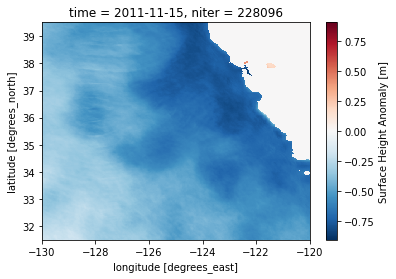

In [12]:
ds_tile.Eta.isel(time=0).plot.pcolormesh(x='XC',y='YC')

In [13]:
cluster.close()

In [14]:
#ds_tiles = [_ds.persist() for _ds in ds_tiles]
# 220GB in RAM against 750 GB observed

In [15]:
dirs["run"]

'/home1/scratch/slgentil/parcels/californie_T30j_dt1j_dij50/run'

In [16]:
df = pa.load_nc(dirs["run"], index='time', persist=True)
df.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity
time,,,,,,,,,
2011-11-15 00:00:00,0,31.600000,-127.500000,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
2011-11-15 01:00:00,0,31.595675,-127.500216,0.0,-2.139593e-07,-1.399217e-06,-0.341830,17.750656,33.328491
2011-11-15 02:00:00,0,31.591494,-127.501845,0.0,9.397034e-08,-1.011560e-06,-0.278828,17.743690,33.327209
2011-11-15 03:00:00,0,31.587564,-127.506839,0.0,-1.051156e-06,-1.303293e-06,-0.161748,17.742025,33.329556
2011-11-15 04:00:00,0,31.584597,-127.514489,0.0,-1.731820e-06,-8.695911e-07,0.006419,17.735298,33.330250


In [17]:
tmin = str(df.index.min().compute() )
tmax = str(df.index.max().compute())
print(tmin, tmax)

2011-11-15 00:00:00 2011-11-25 00:00:00


In [18]:
tmin = str(df.index.min().compute())
tmax = str(df.index.max().compute())
print(tmin, tmax)

2011-11-15 00:00:00 2011-11-25 00:00:00


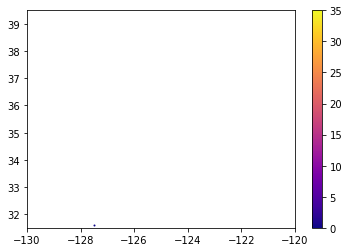

In [19]:

_df = df.loc[tmin].compute()
plt.scatter(_df['lon'], _df['lat'], s=1, c=_df['temperature'], 
            vmin=0, vmax=35, cmap='plasma')
plt.xlim(lonmin,lonmax)
plt.ylim(latmin,latmax)
plt.colorbar()

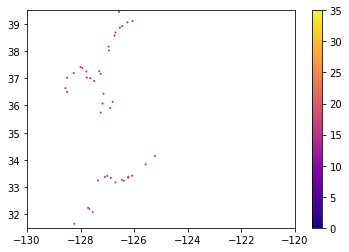

In [20]:
_df = df.loc[tmax, :].compute()
plt.scatter(_df['lon'], _df['lat'], s=1, c=_df['temperature'], 
            vmin=0, vmax=35, cmap='plasma')
plt.xlim(lonmin,lonmax)
plt.ylim(latmin,latmax)
plt.colorbar()

## Close cluster

In [21]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
